In [1]:
import numpy as np

try:
    from modAL.models import ActiveLearner
except:
    !pip3 install modAL

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
    return images, labels

X_train, y_train = load_mnist('fashion-MNIST', kind='train')
X_test, y_test = load_mnist('./fashion-MNIST', kind='t10k')

test_size = 100
test_idx = np.random.choice(range(len(X_test)), size=test_size, replace=False)
X_test = X_test[test_idx]
y_test = y_test[test_idx]
print('Train', X_train.shape)
print('Test', X_test.shape)
#normalize
X_train = X_train/255.0
X_test = X_test/255.0

Train (60000, 784)
Test (100, 784)


In [3]:
n_initial = 1000

#random index from training set
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

#select random samples
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

print('Pool: ', X_pool.shape)
print('Init: ', X_initial.shape)

Pool:  (59000, 784)
Init:  (1000, 784)


In [4]:
# Use Gaussian navie bayes for classifier
learner = ActiveLearner(
    estimator=GaussianNB(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

Query  99 / 100
[9227]
[0]


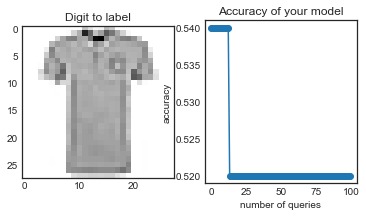

In [22]:
n_queries = 100
accuracy_scores = [learner.score(X_test, y_test)]
for i in range(n_queries):
    query_idx, query_inst = learner.query(X_pool)
    y_new = y_pool[query_idx]#np.array([int(input())], dtype=int)
    if i % 10 >= 0:
      display.clear_output(wait=True)
      print("Query ", i, "/", n_queries)
      print(query_idx)
      #print(query_inst)
      print(y_new)
      with plt.style.context('seaborn-white'):
          plt.figure(figsize=(6, 3))
          plt.subplot(1, 2, 1)
          plt.title('Digit to label')
          plt.imshow(query_inst.reshape(28, 28))
          plt.subplot(1, 2, 2)
          plt.title('Accuracy of your model')
          plt.plot(range(i+1), accuracy_scores)
          plt.scatter(range(i+1), accuracy_scores)
          plt.xlabel('number of queries')
          plt.ylabel('accuracy')
          display.display(plt.gcf())
          plt.close('all')

    learner.teach(query_inst.reshape(1, -1), y_new)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(X_test, y_test))

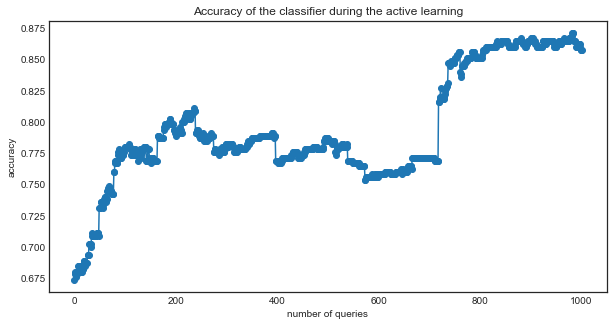

In [14]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries+1), accuracy_scores)
    plt.scatter(range(n_queries+1), accuracy_scores)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

In [15]:
print("- The first acc: {}\n- The last acc: {}".format(accuracy_scores[0], accuracy_scores[-1]))

- The first acc: 0.6733333333333333
- The last acc: 0.8577777777777778
